In [63]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized , acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed
from fireworks.particles import Particles

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Let's put in the particles (rebember that the units are Nbody units).

In [44]:
tevolve    = 65
position   = np.array([[0.,0.,0.],[0.5, 0.866,0],[1,0,0]])
velocity   = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
mass       = np.array([3.,4.,5.])
P          = Particles(position,velocity,mass)
print(P.pos )                                                                  # particles'positions
print(P.vel )                                                                  # particles'velocities
print(P.mass)                                                                  # particles'masses
print(P.ID  )                                                                  # particles'unique IDs


[[0.    0.    0.   ]
 [0.5   0.866 0.   ]
 [1.    0.    0.   ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[3. 4. 5.]
[0 1 2]


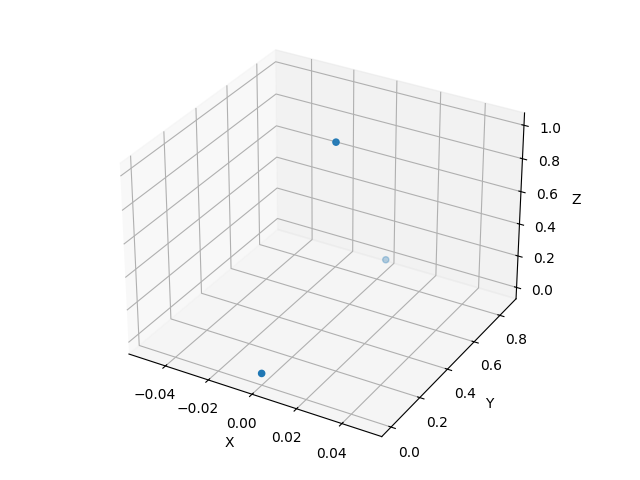

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P.pos[0,:], P.pos[1,:], P.pos[2,:] )
#ax.scatter(P.pos[0,:], label=f'$M_1$', color='C0')
#ax.scatter(P.pos[1,:], label=f'$M_2$', color='C1')
#ax.scatter(P.pos[2,:], label=f'$M_3$', color='C2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

### TSUNAM EVOLUTION

Now we can evolve the system using the TSUNAMI integrator. 

As initial condition we put $t_{start}$ = 0$ and $t_{simulation} = t_{evolve} = 65$ defined previously. To perform the integration we devide this interval in $n = METTERE QUANTO$ parts linearly spaced.

In [46]:
def integration_with_tsunami_3body(part, tsimulation):
    tstart=0
    tintermediate = np.linspace(tstart, tsimulation, 20)
    tcurrent=0
    pos1_tsu = []
    pos2_tsu = []
    pos3_tsu = []
    #Epot_tsu = []
    #Ekin_tsu = []
    #Etot_tsu = []
    t_tsunami = []

    for t in tintermediate:
        tstep=t-tcurrent
        if tstep <=0: continue 
        part_tsunami, efftime,_,_,_=integrator_tsunami(part, tstep)

        #I append the positions
        pos1_tsu.append(part_tsunami.pos[0].copy())
        pos2_tsu.append(part_tsunami.pos[1].copy())
        pos3_tsu.append(part_tsunami.pos[2].copy())

        #I append the energies
        #Etot_n, Ekin_n, Epot_n =  part_tsunami.Etot()
        #Etot_tsu.append(Etot_n)
        #Ekin_tsu.append(Ekin_n)
        #Epot_tsu.append(Epot_n)

        #I append the times
        t_tsunami.append(tcurrent)

        tcurrent=tcurrent+efftime

    #I transform everything in numpy arrays
    pos1_tsu    = np.array(pos1_tsu)
    pos2_tsu    = np.array(pos2_tsu)
    pos3_tsu    = np.array(pos3_tsu)
    #Epot_tsu    = np.array(Epot_tsu)
    #Ekin_tsu    = np.array(Ekin_tsu)
    #Etot_tsu    = np.array(Etot_tsu)
    t_tsunami   = np.array(t_tsunami)


    return pos1_tsu, pos2_tsu, pos3_tsu, t_tsunami #, Epot_tsu, Ekin_tsu, Etot_tsu

In [47]:
P_tsu = P.copy()

In [48]:
pos1_tsu, pos2_tsu, pos3_tsu, t_tsu = integration_with_tsunami_3body(P_tsu, tevolve)

In [49]:
print(pos1_tsu)
print(pos2_tsu)
print(pos3_tsu)

[[  624.51020268   117.76792744     0.        ]
 [ 1313.60256364   247.71453419     0.        ]
 [ 2002.69436501   377.66103539     0.        ]
 [ 2691.78648668   507.60759679     0.        ]
 [ 3380.87850316   637.55413832     0.        ]
 [ 4069.97062186   767.50069902     0.        ]
 [ 4759.06262352   897.44723756     0.        ]
 [ 5448.15471613  1027.39379311     0.        ]
 [ 6137.24664318  1157.34031745     0.        ]
 [ 6826.33866081  1287.28685864     0.        ]
 [ 7515.430773    1417.23341747     0.        ]
 [ 8204.52295164  1547.17998857     0.        ]
 [ 8893.6147434   1677.12648689     0.        ]
 [ 9582.70677101  1807.07302955     0.        ]
 [10271.79884258  1937.01958033     0.        ]
 [10960.89094757  2066.96613709     0.        ]
 [11649.98286445  2196.91265813     0.        ]
 [12339.07487672  2326.85919713     0.        ]
 [13028.16689895  2456.8057381      0.        ]]
[[ -208.17006008   -39.25590782     0.        ]
 [ -437.86751265   -82.57142617     0. 

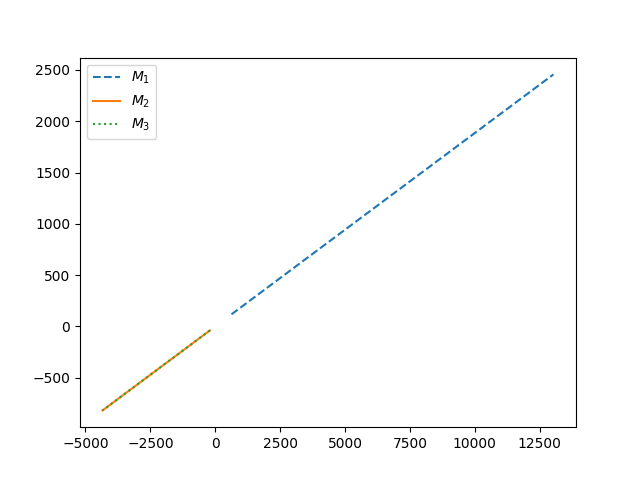

In [58]:
plt.figure()
plt.plot(pos1_tsu[:,0]  , pos1_tsu[:,1], label=f'$M_1$', linestyle='dashed' ) # , pos1_tsu[:,2])
plt.plot(pos2_tsu[:,0]  , pos2_tsu[:,1], label=f'$M_2$') # , pos2_tsu[:,2])
plt.plot(pos3_tsu[:,0]  , pos3_tsu[:,1], label=f'$M_3$', linestyle='dotted' ) # , pos3_tsu[:,2])
plt.legend()
plt.show()

### OTHER INTEGRATORS

Let's begin with the `euler integrator` and let's use the `acceleration_pyfalcon`. These are the fastest among the other analogous competitors.

In [59]:
def integration_euler(part, h, tsimulation, t, N, softening):
    path_1 = []
    path_2 = []
    path_3 = []
    #Etot_euler = []
    #Ekin_euler = []
    #Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_pyfalcon, softening)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            path_3.append(updated_part.pos[2])
            #Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            #Etot_euler.append(Etot_n)
            #Ekin_euler.append(Ekin_n)
            #Epot_euler.append(Epot_n)

        t += h

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    path_3 = np.array(path_3)
    #Etot_euler = np.array(Etot_euler)
    #Ekin_euler = np.array(Ekin_euler)
    #Etot_euler = np.array(Epot_euler)

    return path_1, path_2, path_3, #, Etot_euler, Ekin_euler, Epot_euler

In [82]:
P_euler = P.copy()
h = 1
N = 3
t = 0
softening = 0

path_1_euler, path_2_euler, path_3_euler = integration_euler(P_euler, h, tevolve, t, N, softening)

In [83]:
print(path_1_euler)

[[   0.            0.            0.        ]
 [   7.00013256    3.46422863    0.        ]
 [  21.00039768   10.39268589    0.        ]
 [  34.9428151    17.292516      0.        ]
 [  48.87951854   24.18951843    0.        ]
 [  62.81420441   31.08552242    0.        ]
 [  76.74786911   37.98102106    0.        ]
 [  90.68091875   44.87621533    0.        ]
 [ 104.6135578    51.7712064     0.        ]
 [ 118.54590341   58.66605227    0.        ]
 [ 132.47802894   65.56078921    0.        ]
 [ 146.40998329   72.45544145    0.        ]
 [ 160.34180072   79.35002593    0.        ]
 [ 174.27350614   86.24455498    0.        ]
 [ 188.20511824   93.13903785    0.        ]
 [ 202.13665139  100.03348165    0.        ]
 [ 216.06811687  106.92789196    0.        ]
 [ 229.99952371  113.82227325    0.        ]
 [ 243.93087926  120.71662916    0.        ]
 [ 257.86218956  127.61096267    0.        ]
 [ 271.79345963  134.50527628    0.        ]
 [ 285.72469371  141.39957208    0.        ]
 [ 299.655

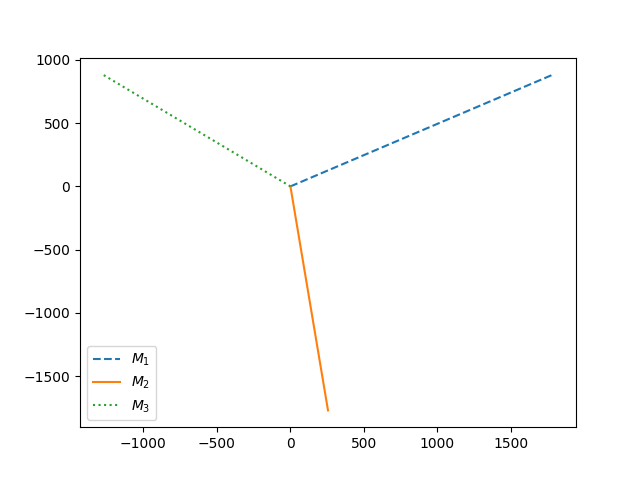

In [84]:
plt.figure()
plt.plot(path_1_euler[:,0]  , path_1_euler[:,1], label=f'$M_1$', linestyle='dashed' ) # , pos1_tsu[:,2])
plt.plot(path_2_euler[:,0]  , path_2_euler[:,1], label=f'$M_2$') # , pos2_tsu[:,2])
plt.plot(path_3_euler[:,0]  , path_3_euler[:,1], label=f'$M_3$', linestyle='dotted' ) # , pos3_tsu[:,2])
plt.legend()
plt.show()